### 使用torch.nn模块实现模型
- 首先，导入torch.nn模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层
- nn就是利用autograd来定义模型。nn的核心数据结构是Module，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层
- 一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法。

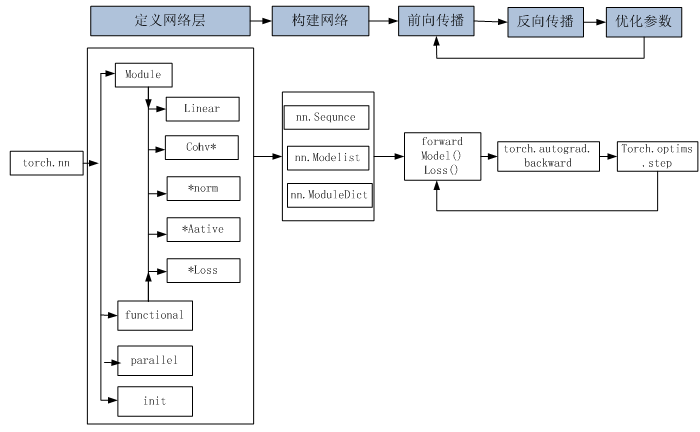

#### Python的继承

In [1]:
class Animal(object):  #  python3中所有类都可以继承于object基类
   def __init__(self, name, age):
       self.name = name
       self.age = age

   def call(self):
       print(self.name, '会叫')
# 现在我们需要定义一个Cat猫类继承于Animal，猫类比动物类多一个sex属性。
class Cat(Animal):
    def __init__(self,name,age,sex):
        # 初始化父类
        super(Cat, self).__init__(name,age)  # 不要忘记从Animal类引入属性
        self.sex=sex

if __name__ == '__main__':  # 单模块被引用时下面代码不会受影响，用于调试
   c = Cat('喵喵', 2, '男')  #  Cat继承了父类Animal的属性
c.call()  # 输出 喵喵 会叫 ，Cat继承了父类Animal的方法 

喵喵 会叫


In [2]:
c.name

'喵喵'

### 使用工具箱自定义线性模型

In [3]:
import numpy as np
import torch
from torch import nn

#### 创建数据

In [4]:
torch.manual_seed(42)
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [5]:
features

tensor([[-0.6125, -0.8488],
        [-0.1602,  1.1580],
        [ 0.5356, -1.6010],
        ...,
        [-1.1370,  0.1979],
        [ 0.3674, -0.4714],
        [ 1.7533, -0.7019]])

In [6]:
features.shape

torch.Size([1000, 2])

In [7]:
labels.shape

torch.Size([1000])

(array([  2.,  10.,  39., 123., 211., 242., 214., 112.,  39.,   8.]),
 array([-3.5622528 , -2.9158313 , -2.2694097 , -1.6229882 , -0.9765667 ,
        -0.33014512,  0.3162764 ,  0.9626979 ,  1.6091194 ,  2.255541  ,
         2.9019625 ], dtype=float32),
 <a list of 10 Patch objects>)

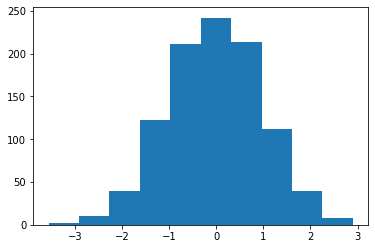

In [8]:
import matplotlib.pyplot as plt
plt.hist(features[:,0])

In [9]:
help(nn.Module)

Help on class Module in module torch.nn.modules.module:

class Module(builtins.object)
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  :ivar training: Boolean represents whether this module is in training or
 |                  eval

#### 定义模型

In [10]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__() # 不继承父类的属性
        self.linear = nn.Linear(n_feature, 1) #in_features, out_features, bias=True
        for item in self.linear.parameters():
            nn.init.normal_(item,mean=0,std=0.01)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
    
linet = LinearNet(num_inputs)
print(linet) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [11]:
for param in linet.parameters():
    print(param)

Parameter containing:
tensor([[-0.0083, -0.0161]], requires_grad=True)
Parameter containing:
tensor([-0.0021], requires_grad=True)


#### 初始化模型参数

In [12]:
net = nn.Linear(2,1)
# 初始化一个符合正态分布的参数
nn.init.normal_(net.weight,mean=0,std=0.01)

Parameter containing:
tensor([[0.0030, 0.0038]], requires_grad=True)

In [13]:
# 初始化一个常数项
nn.init.constant_(net.bias,val=0)

Parameter containing:
tensor([0.], requires_grad=True)

#### 损失函数

In [14]:
loss = nn.MSELoss()

#### 优化算法
torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等

In [15]:
linet.parameters()

<generator object Module.parameters at 0x0000017BBB4DC120>

In [16]:
import torch.optim as optim
optimizer = optim.SGD(linet.parameters(),lr=0.03) # 待优化的参数,学习率
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


#### 训练模型

In [17]:
# 创建加载器
import torch.utils.data as Data
batch_size = 32
# 创建特征和标签组合的数据
dataset = Data.TensorDataset(features,labels)  # 类似于zip的功能
# 随机读取小批量数据
data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)

In [18]:
data_iter

In [19]:
num_epochs = 20
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        # 1.预测
        pred = linet(X)
        # 2.损失
        l = loss(pred,y.view(-1,1))
        # 3.梯度清零
        optimizer.zero_grad()
        # 4.反向传播
        l.backward()
        # 5.更新网络参数
        optimizer.step()
    print("epoch{},loss:{}".format(epoch,l.item()))

epoch1,loss:0.5122741460800171
epoch2,loss:0.021532321348786354
epoch3,loss:0.0004052929871249944
epoch4,loss:5.809686263091862e-05
epoch5,loss:8.557118417229503e-05
epoch6,loss:0.00011170953075634316
epoch7,loss:2.522894283174537e-05
epoch8,loss:0.000145496116601862
epoch9,loss:6.706478598061949e-05
epoch10,loss:0.00022185142734088004
epoch11,loss:5.2367544412845746e-05
epoch12,loss:0.00011769100092351437
epoch13,loss:2.7240275812800974e-05
epoch14,loss:0.00018082010501530021
epoch15,loss:0.00014699908206239343
epoch16,loss:0.00016953307203948498
epoch17,loss:0.00011443129915278405
epoch18,loss:6.706036219839007e-05
epoch19,loss:9.317143849330023e-05
epoch20,loss:0.0001236753014381975


In [20]:
num_epochs = 20
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        # 1.预测
        pred = linet(X)
        # 2.损失
        l = loss(pred,y.view(-1,1))  
        # 3.反向传播
        l.backward()
        # 4.更新网络参数
        optimizer.step()
        # 5.梯度清零
        optimizer.zero_grad()
    print("epoch{},loss:{}".format(epoch,l.item()))

epoch1,loss:0.00017924135318025947
epoch2,loss:0.0001212637362186797
epoch3,loss:0.00014573422959074378
epoch4,loss:0.00012061364395776764
epoch5,loss:0.00010241870040772483
epoch6,loss:6.0643204051302746e-05
epoch7,loss:8.196449198294431e-05
epoch8,loss:0.00012336728104855865
epoch9,loss:2.7485803002491593e-05
epoch10,loss:6.0027825384167954e-05
epoch11,loss:0.0001061605871655047
epoch12,loss:6.802917778259143e-05
epoch13,loss:8.241840987466276e-05
epoch14,loss:0.00010779134754557163
epoch15,loss:0.00016782690363470465
epoch16,loss:4.193566564936191e-05
epoch17,loss:0.00015191390411928296
epoch18,loss:6.080342791392468e-05
epoch19,loss:0.0001396109873894602
epoch20,loss:0.0001960296940524131


### Mnist手写数字识别

（1）利用Pytorch内置函数mnist下载数据

（2）利用torchvision对数据进行预处理，调用torch.utils建立一个数据迭代器

（3）可视化源数据

（4）利用nn工具箱构建神经网络模型

（5）实例化模型，并定义损失函数及优化器

（6）训练模型

（7）可视化结果

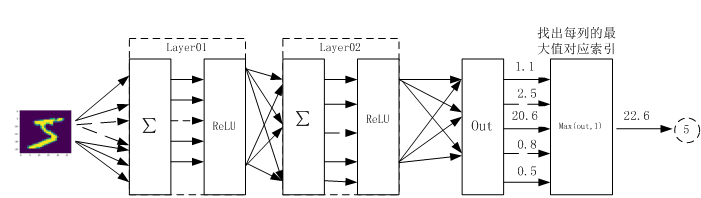

In [21]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [22]:
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [23]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform,download = True)
#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#### 说明

①transforms.Compose可以把一些转换函数组合在一起；

②Normalize([0.5], [0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如三个通道，应该是Normalize([m1,m2,m3], [n1,n2,n3])

③download参数控制是否需要下载，如果./data目录下已有MNIST，可选择False。

④用DataLoader得到生成器，这可节省内存。

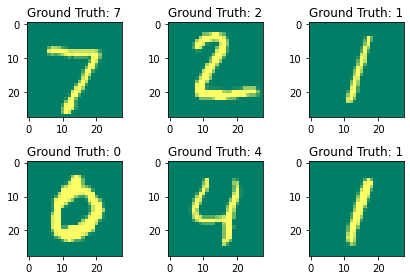

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
 
 
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
 
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='summer', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))

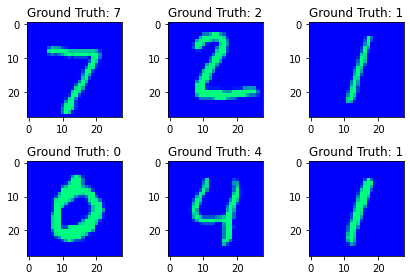

In [25]:
i = 0
for batch_idx, (example_data, example_targets) in enumerate(test_loader):
    while i < 6:
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0],cmap='winter')
        plt.title('Ground Truth: {}'.format(example_targets[i]))
        i+=1

In [26]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, z):
        z = F.relu(self.layer1(z))
        z = F.relu(self.layer2(z))
        z = self.layer3(z)
        return z

In [27]:
#检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
 
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [28]:
# 开始训练
losses = [] #训练
acces = []
eval_losses = [] #评估
eval_acces = []
 
 
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    # 训练模式
    model.train()
    #动态修改参数学习率 
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        # 计算损失
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        # 参数更新
        optimizer.step()
        # 记录误差
        train_loss += loss.item() #python
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0297, Train Acc: 0.7843, Test Loss: 0.5442, Test Acc: 0.9033
epoch: 1, Train Loss: 0.4759, Train Acc: 0.9001, Test Loss: 0.3490, Test Acc: 0.9245
epoch: 2, Train Loss: 0.3453, Train Acc: 0.9203, Test Loss: 0.2700, Test Acc: 0.9375
epoch: 3, Train Loss: 0.2800, Train Acc: 0.9331, Test Loss: 0.2251, Test Acc: 0.9459
epoch: 4, Train Loss: 0.2395, Train Acc: 0.9417, Test Loss: 0.1963, Test Acc: 0.9524
epoch: 5, Train Loss: 0.2190, Train Acc: 0.9468, Test Loss: 0.1936, Test Acc: 0.9521
epoch: 6, Train Loss: 0.2166, Train Acc: 0.9468, Test Loss: 0.1903, Test Acc: 0.9532
epoch: 7, Train Loss: 0.2147, Train Acc: 0.9479, Test Loss: 0.1892, Test Acc: 0.9529
epoch: 8, Train Loss: 0.2114, Train Acc: 0.9486, Test Loss: 0.1855, Test Acc: 0.9543
epoch: 9, Train Loss: 0.2099, Train Acc: 0.9487, Test Loss: 0.1821, Test Acc: 0.9554
epoch: 10, Train Loss: 0.2082, Train Acc: 0.9491, Test Loss: 0.1831, Test Acc: 0.9543
epoch: 11, Train Loss: 0.2070, Train Acc: 0.9488, Test Loss: 0.1

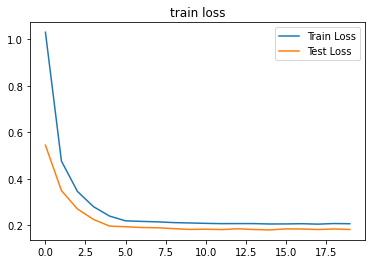

In [29]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(eval_losses)),eval_losses)
plt.legend(['Train Loss','Test Loss'], loc='upper right')